In [1]:
import os
# 원하는 디렉토리로 이동
os.chdir("/workspace")
# 현재 작업 디렉토리 확인
print("Current working directory:", os.getcwd())

Current working directory: /workspace


In [174]:
# Cell 1 : Import Libraries

import numpy as np
import os
import random
import math
import time
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch.utilities import CombinedLoader

from src.util import random_crop, random_mask, random_multiply

# (src.model.models_cola) 안의 Cola, ColaMD 모델
from src.model.models_cola import Cola, ColaMD

# # sys.path 추가 후 import 하는 방식 사용 가능:
# #import sys
# #sys.path.append('src')  # src 폴더 경로를 PYTHONPATH에 추가
# from util import random_crop, random_mask, random_multiply
# from model.models_cola import Cola, ColaMD


In [3]:
# Cell 2 : Combine DataLoaders and AudioDataset

class AudioDataset(torch.utils.data.Dataset):
    """
    오디오 (스펙트로그램) 데이터를 contrastive 학습 방식(cola)에 맞게
    x1, x2로 증강하여 리턴하는 Dataset 클래스
    """
    def __init__(
        self, data, max_len=200, augment=True, from_npy=False,
        labels=None, method="cola"
    ):
        """
        Args:
            data: 파일경로 리스트 or numpy 배열 리스트
            max_len: random_crop 시 사용할 크기
            augment: True면 random_mask, random_multiply 같은 증강 적용
            from_npy: True면 data[idx]+".npy" 파일을 로드
            labels: 지도학습 시 필요한 레이블 (없으면 None)
            method: "cola" (contrastive)
        """
        self.data = data
        self.max_len = max_len
        self.augment = augment
        self.from_npy = from_npy
        self.labels = labels
        self.method = method

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # npy 파일로부터 로드할지 여부 결정
        if self.from_npy:
            npy_path = self.data[idx]
            x = np.load(npy_path)# + ".npy")
        else:
            x = self.data[idx]

        if self.method == "cola":
            # 콜라 방식 증강
            if self.augment:
                x = random_mask(x)

            x1 = random_crop(x, crop_size=self.max_len)
            x2 = random_crop(x, crop_size=self.max_len)

            if self.augment:
                x1 = random_multiply(x1)
                x2 = random_multiply(x2)

            x1 = torch.tensor(x1, dtype=torch.float)
            x2 = torch.tensor(x2, dtype=torch.float)

            if self.labels is None:
                return x1, x2
            else:
                return (x1, x2), self.labels[idx]

        # 다른 method가 있다면 분기처리 가능
        # (현재는 "cola" 만 사용)
        return x  # fallback


def combine_dataloaders(dataloaders, train=False):
    """
    여러 DataLoader를 하나로 합치는 함수.
    train=True 인 경우, 'max_size_cycle' 모드로
    모든 DataLoader 배치를 에폭 중 균등하게 섞어 쓴다.
    """
    if train:
        return CombinedLoader(dataloaders, 'max_size_cycle')
    else:
        return CombinedLoader(dataloaders, 'sequential')


In [4]:
# Cell 3 : Callback for LR decay

class DecayLearningRate(pl.Callback):
    """
    매 에폭이 끝날 때마다 학습률을 0.99배로 서서히 줄이는 콜백
    """
    def __init__(self):
        super().__init__()
        self.old_lrs = []

    def on_train_start(self, trainer, pl_module):
        for opt_idx, optimizer in enumerate(trainer.optimizers):
            group = []
            for param_group in optimizer.param_groups:
                group.append(param_group["lr"])
            self.old_lrs.append(group)

    def on_train_epoch_end(self, trainer, pl_module):
        for opt_idx, optimizer in enumerate(trainer.optimizers):
            old_lr_group = self.old_lrs[opt_idx]
            new_lr_group = []
            for p_idx, param_group in enumerate(optimizer.param_groups):
                old_lr = old_lr_group[p_idx]
                new_lr = old_lr * 0.99
                new_lr_group.append(new_lr)
                param_group["lr"] = new_lr
            self.old_lrs[opt_idx] = new_lr_group


In [ ]:
# Cell 4 : Main training function

from pytorch_lightning.strategies import DDPStrategy

def train_multiple_data(
    title,
    data_source,         # 예: {"icbhi": 50, "hf_lung":200, "kauh":100, ...}
    dim_fea=1280, 
    dim_hidden=1280, 
    dim_out=512, 
    encoder="htsat", #"efficientnet", 
    n_epoches=50, 
    training_method="cola",
    batch_size=128,
):
    """
    여러 데이터셋을 합쳐서 Self-Supervised Learning(Cola) 방식으로 학습하는 함수

    Args:
        title: (str) 실험 이름 (로그/체크포인트 파일명에 포함)
        data_source: {데이터셋이름: max_len} 형태의 딕셔너리
        ...
    """
    print("=== Data Source ===")
    print(data_source)
    print("===================")

    method = training_method
    epochs = n_epoches

    # 여러 DataLoader를 모아둘 리스트
    train_loaders = []
    val_loaders   = []
    num_batch     = []  # 각 데이터셋의 배치 개수 (ColaMD에서 사용)

    print("=======================================")
    print("Start loading data & constructing loaders...")

    for dt, max_len in data_source.items():
        print(f"\n-- Dataset: {dt}, crop_size={max_len}")

        # 해당 데이터셋별로 npy파일 리스트나 split 정보를 가져옴
        # 기존 예시: icbhi, icbhicycle, hf_lung 은 그대로.
        # 새롭게 kauh, PulmonarySound, SPRSound 케이스 추가.
        from_npy = True

        if dt == "icbhi":
            icbhi_filenames = np.load("data/icbhi/entire_spec_filenames.npy")
            train_test = np.load("data/icbhi/entire_spec_split.npy")
            # train만 추출
            filenames = list(icbhi_filenames[train_test == "train"])

        elif dt == "icbhicycle":
            icbhi_filenames = np.load("data/icbhi/cycle_spec_pad2_name.npy")
            train_test = np.load("data/icbhi/cycle_spec_split.npy")
            filenames = list(icbhi_filenames[train_test == "train"])

        elif dt == "hf_lung":
            filenames = list(np.load("data/hf_lung/entire_spec_filenames.npy"))

        elif dt == "Coswara":
            filenames = list(np.load("data/Coswara-Data/entire_spec_filenames.npy"))

        # ================= 새로 추가한 데이터셋 =================
        elif dt == "kauh":
            filenames = list(np.load("data/KAUH/entire_spec_filenames.npy"))

        elif dt == "PulmonarySound":
            filenames = list(np.load("data/PulmonarySound/entire_spec_filenames.npy"))

        elif dt == "SPRSound":
            filenames = list(np.load("data/SPRSound/entire_spec_filenames.npy"))

        else:
            raise ValueError(f"Unknown dataset name: {dt}")

        # 이 예시에선 단순히 train/val= 9:1 로 split
        # 필요에 따라 8:2, 혹은 사전에 분할된 파일이 있으면 그 파일을 이용.
        from sklearn.model_selection import train_test_split
        train_files, val_files = train_test_split(
            filenames, test_size=0.1, random_state=1337
        )

        # DataSet & DataLoader 구성
        train_data = AudioDataset(
            data=train_files,
            augment=True,
            from_npy=from_npy,
            max_len=max_len,
            method=method
        )
        val_data = AudioDataset(
            data=val_files,
            augment=True,
            from_npy=from_npy,
            max_len=max_len,
            method=method
        )

        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4
        )
        val_loader = DataLoader(
            val_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4
        )

        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

        print(f" => #Train batches: {len(train_loader)} | #Val batches: {len(val_loader)}")
        num_batch.append(len(train_loader))

    # 여러 데이터셋의 loader를 합쳐 CombinedLoader로
    train_loader = combine_dataloaders(train_loaders, train=True)
    val_loader   = combine_dataloaders(val_loaders, train=False)

    # 모델 생성 (method == "cola" 가정)
    if training_method == "cola":
        model = ColaMD(
            encoder=encoder, 
            max_len=data_source,  # dict 자체를 넘겨도 됨(ColaMD 내부에서는 안써도 되긴 함)
            dim_fea=dim_fea,
            dim_hidden=dim_hidden,
            dim_out=dim_out,
            num_batch=num_batch
        )
    else:
        raise NotImplementedError("Only 'cola' is currently supported.")

    # 로그/체크포인트 설정
    logger = CSVLogger(save_dir="cks/logs", name="combined", version=title)

    checkpoint_callback = ModelCheckpoint(
        monitor="valid_loss", 
        mode="min", 
        dirpath="cks/model/combined/" + "_".join(data_source.keys()),
        filename='encoder-' + title + '-{epoch:02d}--{valid_acc:.2f}-{valid_loss:.4f}',
        every_n_epochs=10,   # 예: 10epoch마다 저장
        save_top_k=3         # 상위 3개만 저장
    )

    # # PyTorch Lightning Trainer
    # trainer = pl.Trainer(
    #     max_epochs=epochs,
    #     accelerator="gpu",
    #     devices=1,
    #     logger=logger,
    #     callbacks=[DecayLearningRate(), checkpoint_callback],
    # )

    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="gpu",
        devices=3,             # Use 3 GPUs
        strategy="ddp_notebook",        # Distributed Data Parallel strategy
        logger=logger,
        callbacks=[DecayLearningRate(), checkpoint_callback],
    )




    print("=============== Start SSL Training ===============")
    trainer.fit(model, train_loader, val_loader)

    print("===============   SSL Testing   ===============")
    test_logger = CSVLogger(save_dir="cks/logs", name="combined_test", version=title)
    trainer.logger = test_logger
    trainer.test(model, dataloaders=val_loader)


In [175]:
# Cell 5 : 실제로 함수를 호출하여 학습 실행하기


# 1) 시드 고정 (재현성)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 2) 사용할 데이터셋과 각 max_len 설정
#    icbhi, icbhicycle, hf_lung 고정 + kauh, PulmonarySound, SPRSound 추가
#    실제 max_len 값은 각 데이터 분석 후 적절히 설정 가능.
data_source = {
    "icbhi": 50,
    "icbhicycle": 50,
    "hf_lung": 200,
    #"Coswara":200,
    "kauh": 20,
    "PulmonarySound": 20,
    "SPRSound": 30
}

# 3) 나머지 파라미터 설정
title            = "experiment_wo Coswara_kauh_Pul_20_SPR_20"
dim_hidden       = 1280
dim_out          = 512
encoder_name     = "htsat"  
n_epoches        = 150
training_method  = "cola"
batch_size       = 64

# 4) 학습 함수 실행
train_multiple_data(
    title=title,
    data_source=data_source,
    dim_fea=1280,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    encoder=encoder_name,
    n_epoches=n_epoches,
    training_method=training_method,
    batch_size=batch_size
)


=== Data Source ===
{'icbhi': 50, 'icbhicycle': 50, 'hf_lung': 200, 'kauh': 20, 'PulmonarySound': 20, 'SPRSound': 30}
Start loading data & constructing loaders...

-- Dataset: icbhi, crop_size=50
 => #Train batches: 8 | #Val batches: 1

-- Dataset: icbhicycle, crop_size=50
 => #Train batches: 45 | #Val batches: 5

-- Dataset: hf_lung, crop_size=200
 => #Train batches: 149 | #Val batches: 17

-- Dataset: kauh, crop_size=20
 => #Train batches: 5 | #Val batches: 1

-- Dataset: PulmonarySound, crop_size=20
 => #Train batches: 11 | #Val batches: 2

-- Dataset: SPRSound, crop_size=30
 => #Train batches: 74 | #Val batches: 9
[8, 45, 149, 5, 11, 74]
[0.0273972602739726, 0.1541095890410959, 0.5102739726027398, 0.017123287671232876, 0.03767123287671233, 0.2534246575342466]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]


=============== Start SSL Training ===============



  | Name       | Type         | Params
--------------------------------------------
0 | do         | Dropout      | 0     
1 | encoder    | EncoderHTSAT | 31.3 M
2 | g          | Linear       | 393 K 
3 | layer_norm | LayerNorm    | 1.0 K 
4 | linear     | Linear       | 262 K 
--------------------------------------------
30.9 M    Trainable params
1.1 M     Non-trainable params
32.0 M    Total params
127.928   Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]


===============   SSL Testing   ===============


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7676763949459258
        test_loss           1.0516756772994995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [63]:
def _butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    # highcut이 nyquist 이상이면 조정
    if highcut >= nyq:
        print(f"Warning: highcut ({highcut} Hz) >= Nyquist ({nyq} Hz). Adjusting highcut to {nyq - 1e-3} Hz.")
        highcut = nyq - 1e-3
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def _butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = _butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

from scipy.signal import butter, lfilter

Sampling rate: 4000 Hz


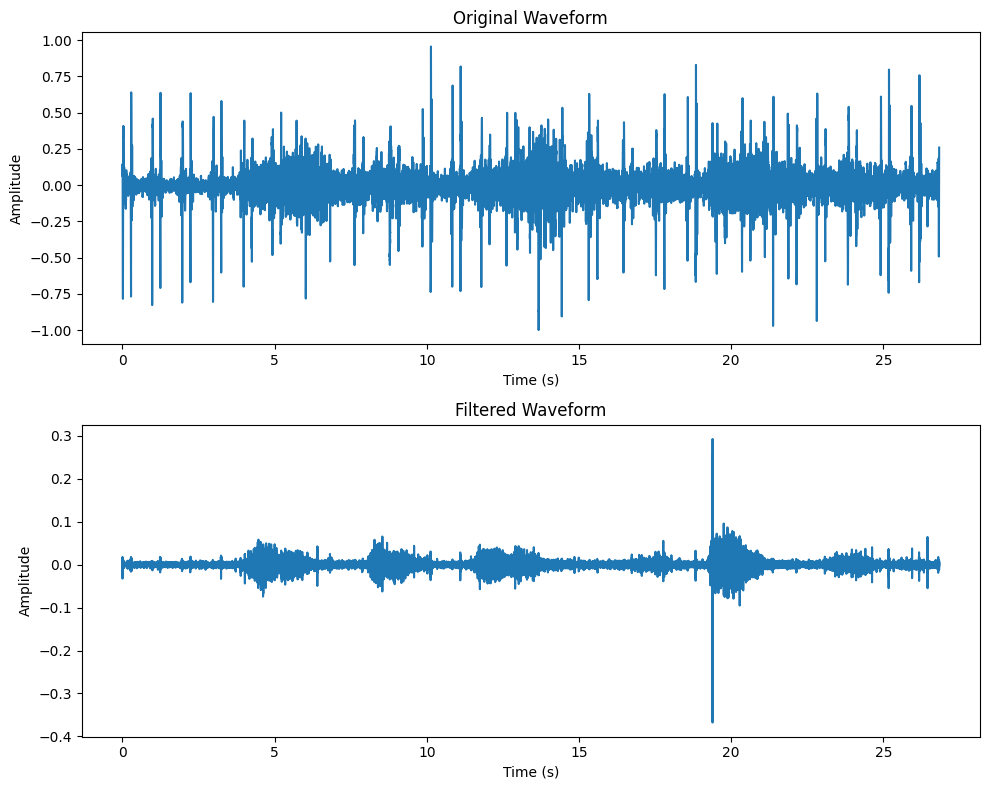

In [145]:
# 1. wav 파일 경로 설정
wav_path = 'H3 D8 normal breathing uc_3.wav' 

# 2. librosa로 wav 파일 불러오기 (원본 sampling rate 유지)
y, sr = librosa.load(wav_path, sr=None)
print(f"Sampling rate: {sr} Hz")

# 3. 밴드패스 필터 적용
# 예시: 음성 대역 (300Hz ~ 3400Hz)
lowcut = 300.0  # 너무 낮은 주파수를 포함하는 경우 노이즈가 많을 수 있음.
highcut = 1600.0
y_filtered = _butter_bandpass_filter(y, lowcut, highcut, fs=sr, order=5)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 원본 파형
axs[0].plot(np.linspace(0, len(y)/sr, num=len(y)), y)
axs[0].set_title("Original Waveform")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# 필터링된 파형
axs[1].plot(np.linspace(0, len(y_filtered)/sr, num=len(y_filtered)), y_filtered)
axs[1].set_title("Filtered Waveform")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [146]:
# ------------------- WAV 파일을 스펙트로그램으로 변환 후 사용하기 -------------------

# 3. melspectrogram 생성
#    - n_mels: mel bin의 개수, hop_length 등 필요한 추가 인자를 설정할 수 있음
S = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128)
# S의 기본 shape: (n_mels, time)

# 4. 시간축이 첫번째 축이 되도록 transpose (AudioDataset에서 crop 진행 시 첫번째 축 기준)
S = S.T  # 이제 shape: (time, n_mels)

# 5. (선택) dB scale로 변환하여 값의 범위를 조절
S_dB = librosa.power_to_db(S, ref=np.max)

# 6. AudioDataset에 넣기 위해 리스트로 wrapping
#    - 여기서는 단일 파일의 spectrogram을 예시로 사용함
data_list = [S_dB]

# 7. AudioDataset 생성
#    - max_len을 spectrogram의 시간 길이보다 작게 설정 (여기서는 128)
dataset = AudioDataset(
    data=data_list,
    max_len=200,    # spectrogram에서 crop할 길이 (시간 프레임 수)
    augment=True,   # 증강을 적용할 경우 True
    from_npy=False, # npy 파일이 아닌 메모리상의 배열 사용
    method="cola"
)

# 8. Data셋에서 첫번째 샘플의 x1, x2 추출
x1, x2 = dataset[0]

print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)

x1 shape: torch.Size([200, 128])
x2 shape: torch.Size([200, 128])


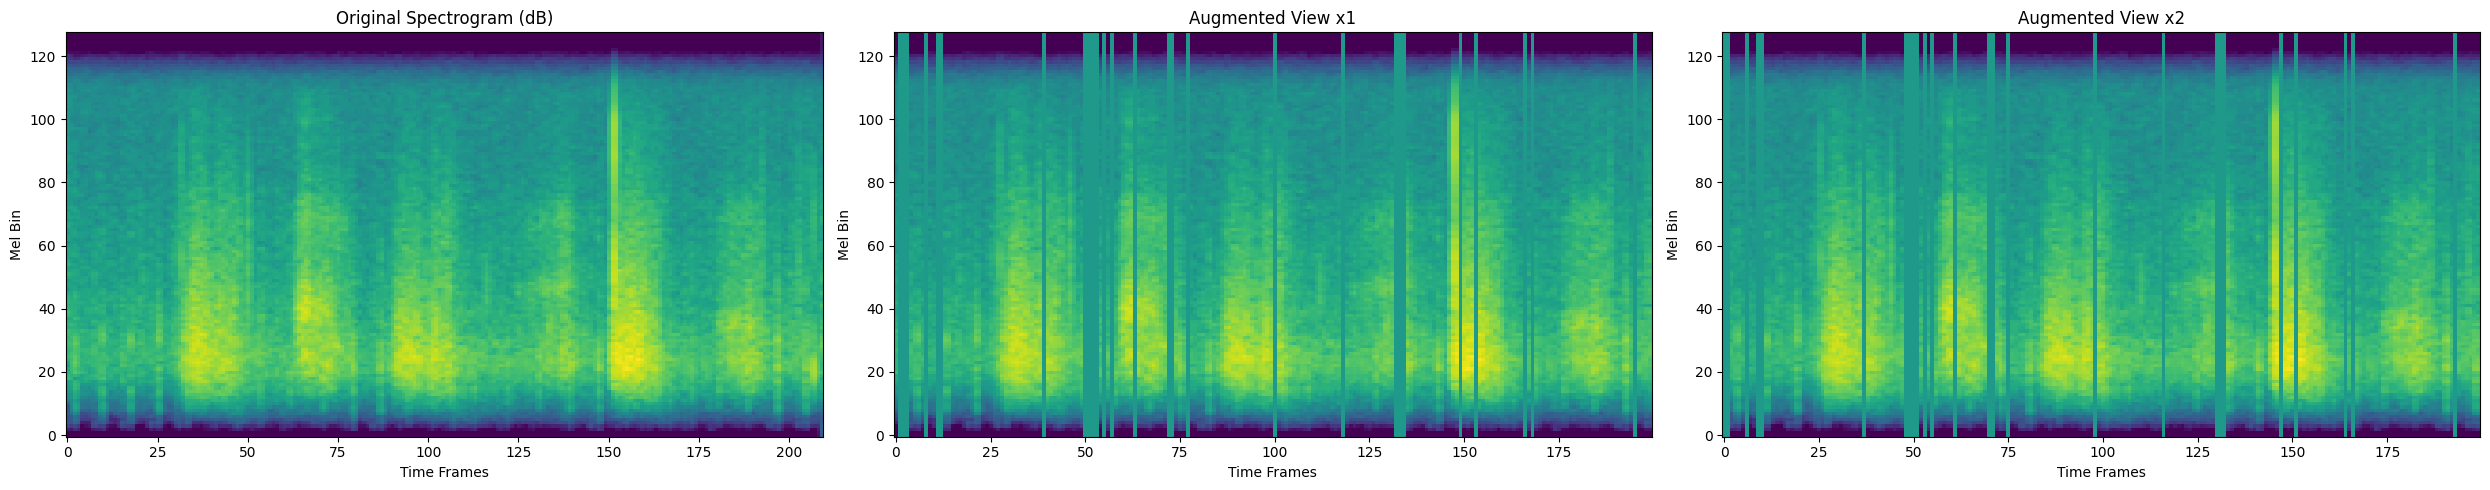

In [147]:
# ------------------- 시각화 -------------------

# Figure 2: 원본 스펙트로그램과 증강된 두 뷰(x1, x2) 비교
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# 원본 스펙트로그램 (dB scale)
axs[0].imshow(S_dB.T, aspect='auto', origin='lower')
axs[0].set_title("Original Spectrogram (dB)")
axs[0].set_xlabel("Time Frames")
axs[0].set_ylabel("Mel Bin")

# Augmented view x1
axs[1].imshow(x1.numpy().T, aspect='auto', origin='lower')
axs[1].set_title("Augmented View x1")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("Mel Bin")

# Augmented view x2
axs[2].imshow(x2.numpy().T, aspect='auto', origin='lower')
axs[2].set_title("Augmented View x2")
axs[2].set_xlabel("Time Frames")
axs[2].set_ylabel("Mel Bin")

plt.tight_layout()
plt.savefig("original.png", dpi=300, bbox_inches='tight')
plt.show()

Sampling rate: 4000 Hz


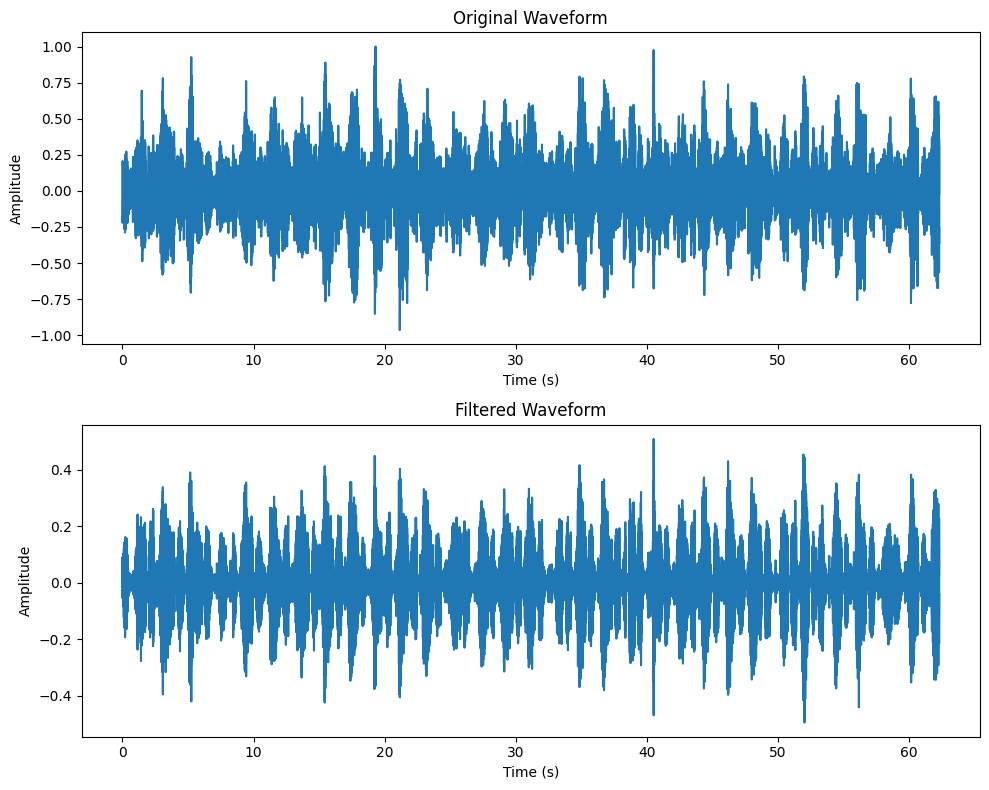

In [148]:
# 1. wav 파일 경로 설정
wav_path = 'WEBSS-005 TP1.wav' 

# 2. librosa로 wav 파일 불러오기 (원본 sampling rate 유지)
y, sr = librosa.load(wav_path, sr=None)
print(f"Sampling rate: {sr} Hz")

# 3. 밴드패스 필터 적용
# 예시: 음성 대역 (300Hz ~ 3400Hz)
lowcut = 300.0  # 너무 낮은 주파수를 포함하는 경우 노이즈가 많을 수 있음.
highcut = 1600.0
y_filtered = _butter_bandpass_filter(y, lowcut, highcut, fs=sr, order=5)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 원본 파형
axs[0].plot(np.linspace(0, len(y)/sr, num=len(y)), y)
axs[0].set_title("Original Waveform")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# 필터링된 파형
axs[1].plot(np.linspace(0, len(y_filtered)/sr, num=len(y_filtered)), y_filtered)
axs[1].set_title("Filtered Waveform")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [149]:
# ------------------- WAV 파일을 스펙트로그램으로 변환 후 사용하기 -------------------

# 3. melspectrogram 생성
#    - n_mels: mel bin의 개수, hop_length 등 필요한 추가 인자를 설정할 수 있음
S = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128)
# S의 기본 shape: (n_mels, time)

# 4. 시간축이 첫번째 축이 되도록 transpose (AudioDataset에서 crop 진행 시 첫번째 축 기준)
S = S.T  # 이제 shape: (time, n_mels)

# 5. (선택) dB scale로 변환하여 값의 범위를 조절
S_dB = librosa.power_to_db(S, ref=np.max)

# 6. AudioDataset에 넣기 위해 리스트로 wrapping
#    - 여기서는 단일 파일의 spectrogram을 예시로 사용함
data_list = [S_dB]

# 7. AudioDataset 생성
#    - max_len을 spectrogram의 시간 길이보다 작게 설정 (여기서는 128)
dataset = AudioDataset(
    data=data_list,
    max_len=200,    # spectrogram에서 crop할 길이 (시간 프레임 수)
    augment=True,   # 증강을 적용할 경우 True
    from_npy=False, # npy 파일이 아닌 메모리상의 배열 사용
    method="cola"
)

# 8. Data셋에서 첫번째 샘플의 x1, x2 추출
x1, x2 = dataset[0]

print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)

x1 shape: torch.Size([200, 128])
x2 shape: torch.Size([200, 128])


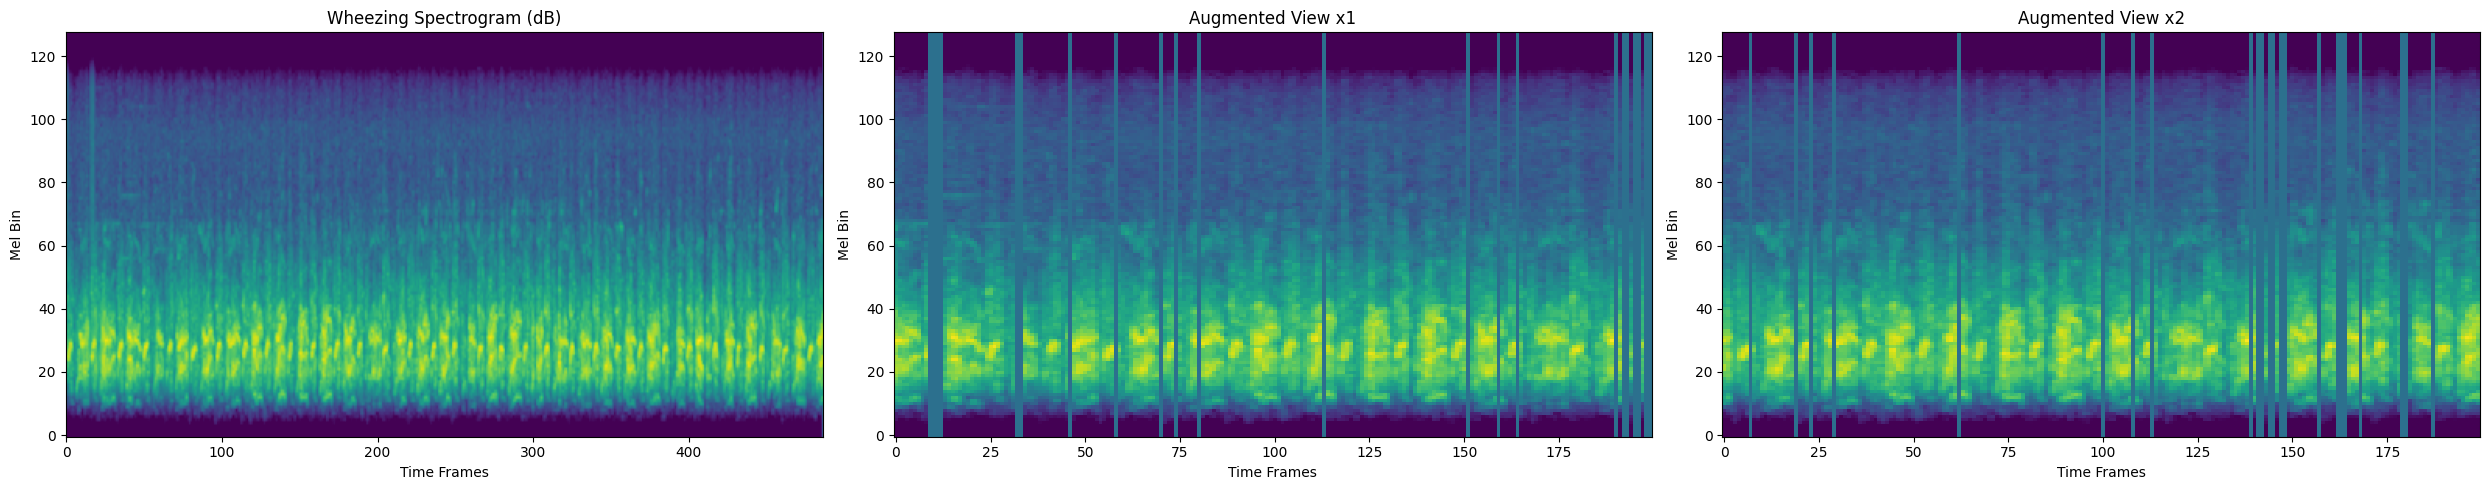

In [150]:
# ------------------- 시각화 -------------------

# Figure 2: 원본 스펙트로그램과 증강된 두 뷰(x1, x2) 비교
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# 원본 스펙트로그램 (dB scale)
axs[0].imshow(S_dB.T, aspect='auto', origin='lower')
axs[0].set_title("Wheezing Spectrogram (dB)")
axs[0].set_xlabel("Time Frames")
axs[0].set_ylabel("Mel Bin")

# Augmented view x1
axs[1].imshow(x1.numpy().T, aspect='auto', origin='lower')
axs[1].set_title("Augmented View x1")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("Mel Bin")

# Augmented view x2
axs[2].imshow(x2.numpy().T, aspect='auto', origin='lower')
axs[2].set_title("Augmented View x2")
axs[2].set_xlabel("Time Frames")
axs[2].set_ylabel("Mel Bin")

plt.tight_layout()
plt.savefig("wheezing.png", dpi=300, bbox_inches='tight')
plt.show()

In [117]:
data_source = {
    "icbhi": 50,
    "icbhicycle": 50,
    "hf_lung": 200,
    "Coswara":200,
    "kauh": 50,
    "PulmonarySound": 50,
    "SPRSound": 50
}

method = "cola"

for dt, max_len in data_source.items():
        print(f"\n-- Dataset: {dt}, crop_size={max_len}")

        # 해당 데이터셋별로 npy파일 리스트나 split 정보를 가져옴
        # 기존 예시: icbhi, icbhicycle, hf_lung 은 그대로.
        # 새롭게 kauh, PulmonarySound, SPRSound 케이스 추가.
        from_npy = True

        if dt == "icbhi":
            icbhi_filenames = np.load("data/icbhi/entire_spec_filenames.npy")
            train_test = np.load("data/icbhi/entire_spec_split.npy")
            # train만 추출
            filenames = list(icbhi_filenames[train_test == "train"])

        elif dt == "icbhicycle":
            icbhi_filenames = np.load("data/icbhi/cycle_spec_pad2_name.npy")
            train_test = np.load("data/icbhi/cycle_spec_split.npy")
            filenames = list(icbhi_filenames[train_test == "train"])

        elif dt == "hf_lung":
            filenames = list(np.load("data/hf_lung/entire_spec_filenames.npy"))

        elif dt == "Coswara":
            filenames = list(np.load("data/Coswara-Data/entire_spec_filenames.npy"))

        # ================= 새로 추가한 데이터셋 =================
        elif dt == "kauh":
            filenames = list(np.load("data/KAUH/entire_spec_filenames.npy"))

        elif dt == "PulmonarySound":
            filenames = list(np.load("data/PulmonarySound/entire_spec_filenames.npy"))

        elif dt == "SPRSound":
            filenames = list(np.load("data/SPRSound/entire_spec_filenames.npy"))

        else:
            raise ValueError(f"Unknown dataset name: {dt}")

        # 이 예시에선 단순히 train/val= 9:1 로 split
        # 필요에 따라 8:2, 혹은 사전에 분할된 파일이 있으면 그 파일을 이용.
        from sklearn.model_selection import train_test_split
        train_files, val_files = train_test_split(
            filenames, test_size=0.1, random_state=1337
        )

        # DataSet & DataLoader 구성
        train_data = AudioDataset(
            data=train_files,
            augment=True,
            from_npy=from_npy,
            max_len=max_len,
            method=method
        )

        #print(dt, "train_data: ",train_data)
        
        val_data = AudioDataset(
            data=val_files,
            augment=True,
            from_npy=from_npy,
            max_len=max_len,
            method=method
        )


-- Dataset: icbhi, crop_size=50

-- Dataset: icbhicycle, crop_size=50

-- Dataset: hf_lung, crop_size=200

-- Dataset: Coswara, crop_size=200

-- Dataset: kauh, crop_size=50

-- Dataset: PulmonarySound, crop_size=50

-- Dataset: SPRSound, crop_size=50


In [122]:
x1, x2 = train_data[0]

In [128]:
state_dict = ckpt['state_dict']
for k, v in state_dict.items():
    print(k, v.shape)

encoder.encoder.htsat.spectrogram_extractor.stft.conv_real.weight torch.Size([513, 1, 1024])
encoder.encoder.htsat.spectrogram_extractor.stft.conv_imag.weight torch.Size([513, 1, 1024])
encoder.encoder.htsat.logmel_extractor.melW torch.Size([513, 64])
encoder.encoder.htsat.bn0.weight torch.Size([64])
encoder.encoder.htsat.bn0.bias torch.Size([64])
encoder.encoder.htsat.bn0.running_mean torch.Size([64])
encoder.encoder.htsat.bn0.running_var torch.Size([64])
encoder.encoder.htsat.bn0.num_batches_tracked torch.Size([])
encoder.encoder.htsat.patch_embed.proj.weight torch.Size([96, 1, 4, 4])
encoder.encoder.htsat.patch_embed.proj.bias torch.Size([96])
encoder.encoder.htsat.patch_embed.norm.weight torch.Size([96])
encoder.encoder.htsat.patch_embed.norm.bias torch.Size([96])
encoder.encoder.htsat.layers.0.blocks.0.norm1.weight torch.Size([96])
encoder.encoder.htsat.layers.0.blocks.0.norm1.bias torch.Size([96])
encoder.encoder.htsat.layers.0.blocks.0.attn.relative_position_bias_table torch.Siz

In [127]:
ckpt_path = "cks/model/combined/icbhi_icbhicycle_hf_lung_Coswara_kauh_PulmonarySound_SPRSound/encoder-test_experiment_transformer-epoch=39--valid_acc=0.84-valid_loss=0.6538.ckpt"
ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))  

print(ckpt.keys())


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [151]:
# CSV 파일 불러오기
csv_path = "cks/logs/combined/test_experiment_transformer/metrics.csv"
df = pd.read_csv(csv_path)

# 열 이름 정리
df.columns = df.columns.str.strip()

# 어떤 column들이 있는지 확인
df.columns.tolist()


['epoch',
 'step',
 'train0_acc',
 'train0_loss',
 'train1_acc',
 'train1_loss',
 'train2_acc',
 'train2_loss',
 'train3_acc',
 'train3_loss',
 'train4_acc',
 'train4_loss',
 'train5_acc',
 'train5_loss',
 'train6_acc',
 'train6_loss',
 'valid_acc',
 'valid_loss']

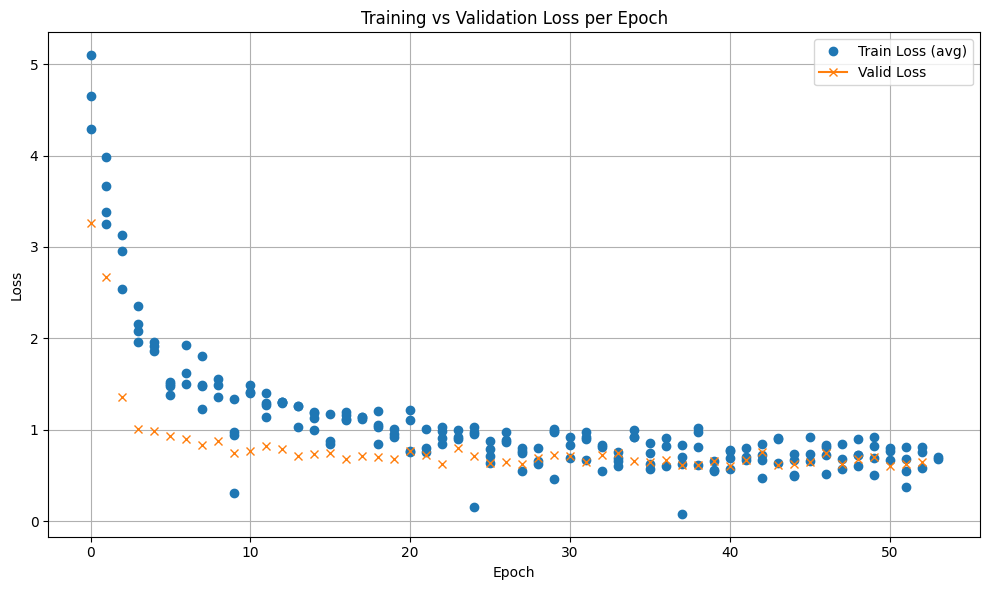

In [161]:
# 각 epoch마다 전체 train loss 평균 계산
train_loss_cols = [col for col in df.columns if "train" in col and "loss" in col]
df["train_avg_loss"] = df[train_loss_cols].mean(axis=1)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df["epoch"], df["train_avg_loss"], label="Train Loss (avg)", marker='o', linestyle='None')
plt.plot(df["epoch"], df["valid_loss"], label="Valid Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_val_loss.png", dpi=300, bbox_inches='tight')
plt.show()


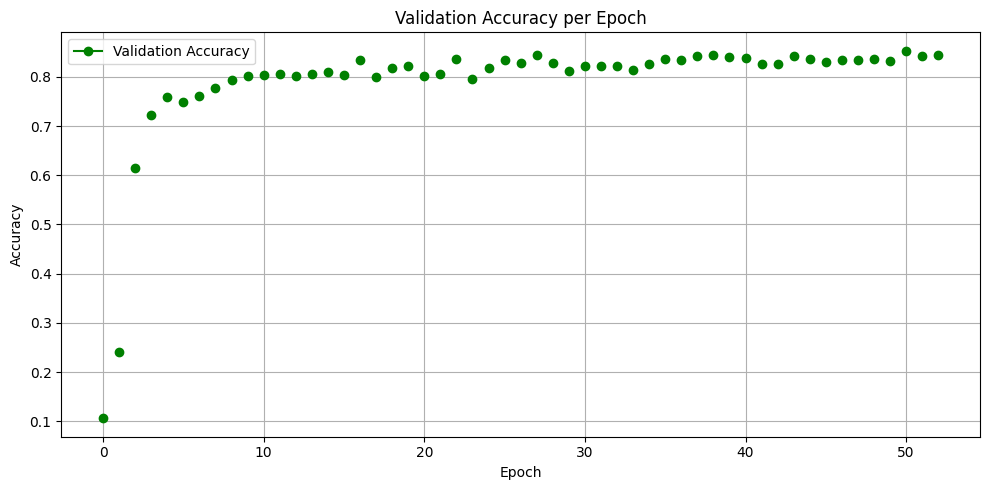

In [162]:
# 시각화: Validation Accuracy per Epoch
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["valid_acc"], label="Validation Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig("val_acc.png", dpi=300, bbox_inches='tight')
plt.show()

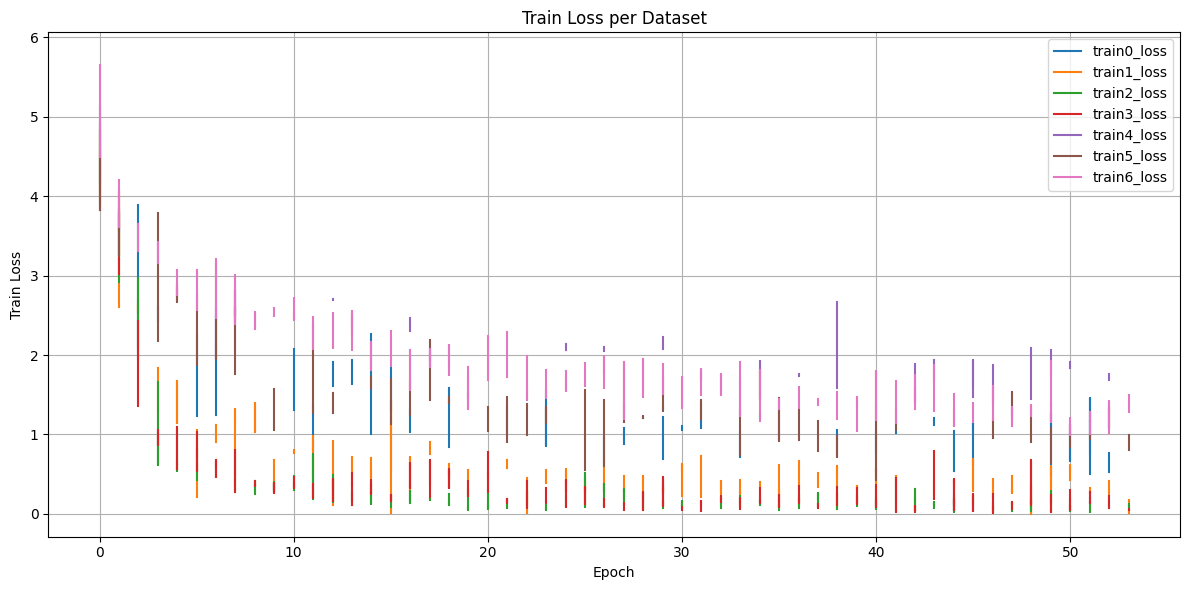

In [163]:
# 데이터셋별 loss 컬럼 시각화
plt.figure(figsize=(12, 6))

for i in range(7):  # train0_loss ~ train6_loss
    col_name = f"train{i}_loss"
    plt.plot(df["epoch"], df[col_name], label=col_name)

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss per Dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_loss per dataset.png", dpi=300, bbox_inches='tight')
plt.show()


In [131]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# 파일 로드
x1 = torch.tensor(np.load("x1.npy")).float()
x1 = x1.unsqueeze(1)
x2 = torch.tensor(np.load("x2.npy")).float()
x2 = x2.unsqueeze(1)

# GPU 사용 가능 시
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x1, x2 = x1.to(device), x2.to(device)


In [132]:
from pytorch_lightning import LightningModule
import torch


# checkpoint 로드
ckpt = torch.load("cks/model/combined/icbhi_icbhicycle_hf_lung_Coswara_kauh_PulmonarySound_SPRSound/encoder-test_experiment_transformer-epoch=39--valid_acc=0.84-valid_loss=0.6538.ckpt", map_location=device)
model = ColaMD.load_from_checkpoint("cks/model/combined/icbhi_icbhicycle_hf_lung_Coswara_kauh_PulmonarySound_SPRSound/encoder-test_experiment_transformer-epoch=39--valid_acc=0.84-valid_loss=0.6538.ckpt")
model = model.to(device)
model.eval()

with torch.no_grad():
    z1 = model.encoder(x1)
    z2 = model.encoder(x2)

[8, 45, 149, 177, 5, 11, 74]
[0.017057569296375266, 0.09594882729211088, 0.31769722814498935, 0.3773987206823028, 0.010660980810234541, 0.023454157782515993, 0.15778251599147122]


Average cosine similarity (x1 vs x2): 0.7055453062057495


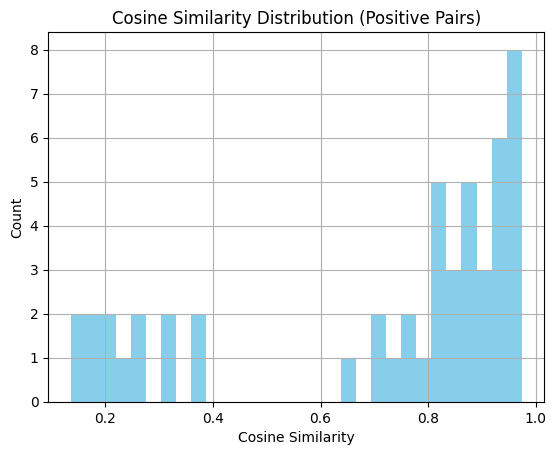

In [164]:
cos_sim = F.cosine_similarity(z1, z2, dim=-1)
print("Average cosine similarity (x1 vs x2):", cos_sim.mean().item())

# 히스토그램 시각화
plt.hist(cos_sim.cpu().numpy(), bins=30, color='skyblue')
plt.title("Cosine Similarity Distribution (Positive Pairs)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.show()

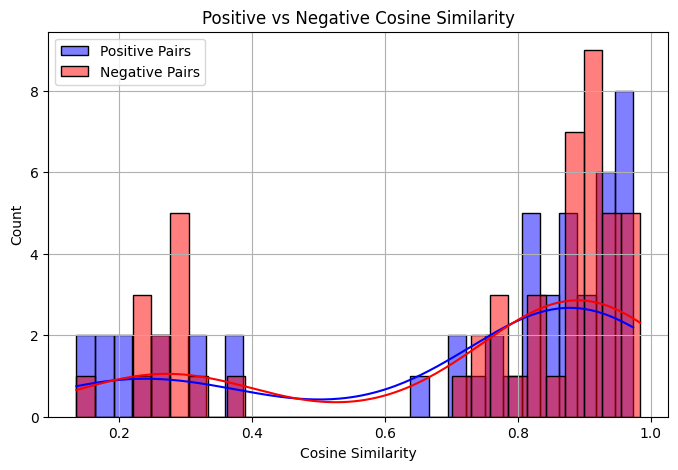

In [134]:
# Negative pairs: z1 vs 다른 샘플 (shuffled z2)
z2_neg = z2[torch.randperm(z2.size(0))]
cos_sim_neg = F.cosine_similarity(z1, z2_neg, dim=-1)

# 시각화
plt.figure(figsize=(8, 5))
sns.histplot(cos_sim.cpu().numpy(), bins=30, color='blue', label="Positive Pairs", kde=True)
sns.histplot(cos_sim_neg.cpu().numpy(), bins=30, color='red', label="Negative Pairs", kde=True)
plt.title("Positive vs Negative Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.legend()
plt.grid(True)
plt.show()

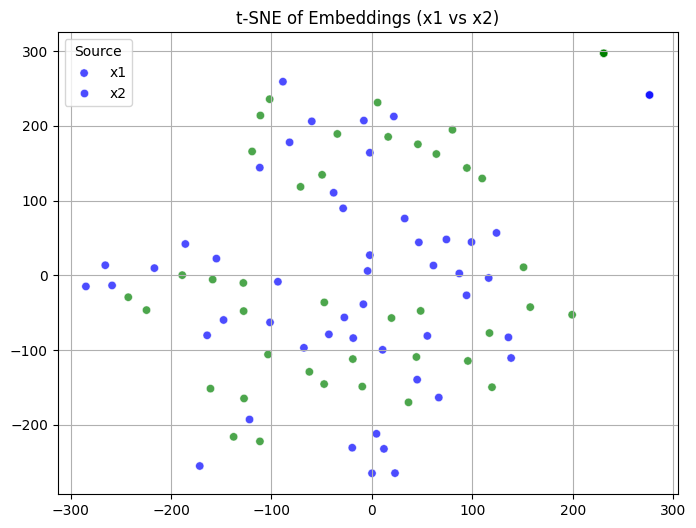

In [135]:
from sklearn.manifold import TSNE

# 두 임베딩 연결
z_all = torch.cat([z1, z2], dim=0).cpu().numpy()
labels = np.array([0]*len(z1) + [1]*len(z2))  # 0: x1, 1: x2

# t-SNE 임베딩
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
z_tsne = tsne.fit_transform(z_all)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_tsne[:,0], y=z_tsne[:,1], hue=labels, palette=["blue", "green"], alpha=0.7)
plt.title("t-SNE of Embeddings (x1 vs x2)")
plt.legend(title="Source", labels=["x1", "x2"])
plt.grid(True)
plt.show()

/opt/conda/envs/audio/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


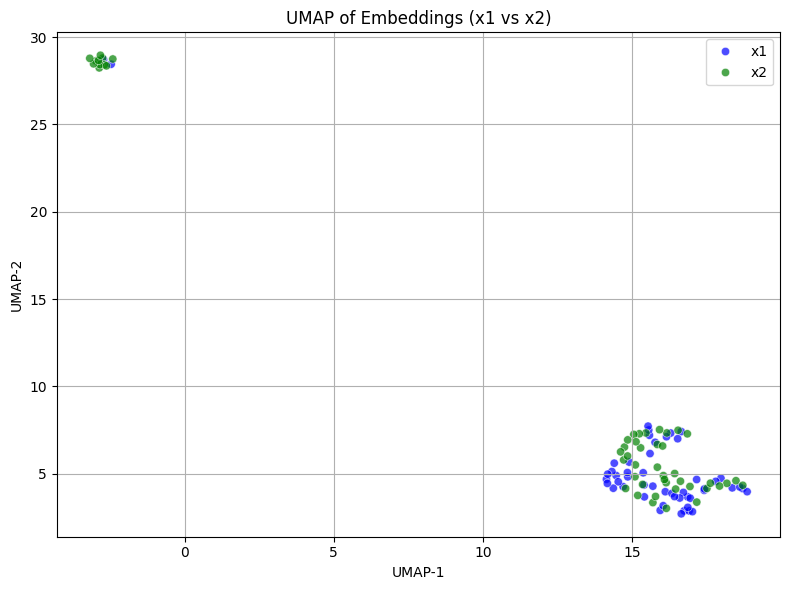

In [165]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 임베딩 연결
z_all = torch.cat([z1, z2], dim=0).cpu().numpy()
labels = np.array(["x1"] * len(z1) + ["x2"] * len(z2))  # 문자열 라벨

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
z_umap = umap_model.fit_transform(z_all)

# 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(x=z_umap[:,0], y=z_umap[:,1], hue=labels, palette={"x1": "blue", "x2": "green"}, alpha=0.7)
plt.title("UMAP of Embeddings (x1 vs x2)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()

plt.savefig("umap.png", dpi=300, bbox_inches='tight')
plt.show()


In [138]:
import torch
import pandas as pd

# cosine similarity 값들 불러오기 (이전 분석에서 z1, z2 사용)
positive_cosine = F.cosine_similarity(z1, z2, dim=-1)
z2_shuffled = z2[torch.randperm(z2.size(0))]
negative_cosine = F.cosine_similarity(z1, z2_shuffled, dim=-1)

# 통계 계산
pos_mean = positive_cosine.mean().item()
pos_std = positive_cosine.std().item()
neg_mean = negative_cosine.mean().item()
neg_std = negative_cosine.std().item()

# 요약표 생성
cosine_stats = pd.DataFrame({
    "Pair Type": ["Positive", "Negative"],
    "Mean Cosine Similarity": [pos_mean, neg_mean],
    "Std. Deviation": [pos_std, neg_std]
})

cosine_stats

,Pair Type,Mean Cosine Similarity,Std. Deviation
0,Positive,0.705545,0.287733
1,Negative,0.728118,0.275839
